📤 Upload image with multiple shapes (e.g., boomerangs):


Saving تصویر صفحه 2025-07-06 133934.png to تصویر صفحه 2025-07-06 133934 (2).png
✅ Image 'تصویر صفحه 2025-07-06 133934 (2).png' loaded.


/tmp/ipython-input-16-1086052213.py:78: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-1086052213.py:78: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


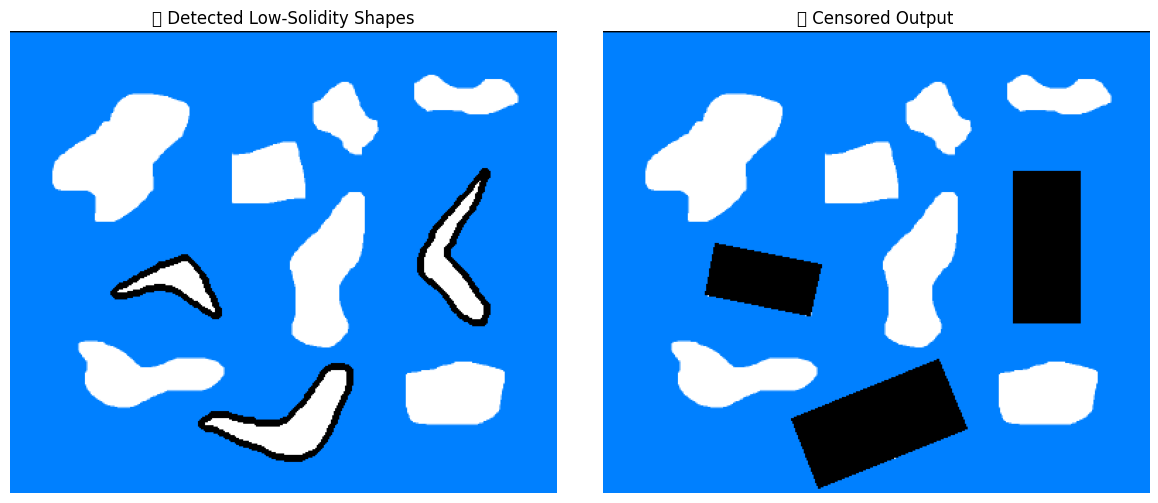

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import files
import io

# Upload image
print("📤 Upload image with multiple shapes (e.g., boomerangs):")
uploaded = files.upload()

# Load image
img = None
for name in uploaded:
    img = Image.open(io.BytesIO(uploaded[name])).convert('RGB')
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    print(f"✅ Image '{name}' loaded.")

# Backup for censoring step
img_orig = img.copy()

# Function to get all contours
def get_all_contours(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Extract contours
contours = get_all_contours(img)
solidity_values = []

# Calculate solidity for each contour
for contour in contours:
    area_contour = cv2.contourArea(contour)
    hull = cv2.convexHull(contour)
    area_hull = cv2.contourArea(hull)
    if area_hull == 0:
        continue
    solidity = float(area_contour) / area_hull
    solidity_values.append(solidity)

# Apply KMeans clustering on solidity values
solidity_np = np.array(solidity_values).reshape((-1, 1)).astype('float32')
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, labels, centers = cv2.kmeans(solidity_np, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
target_cluster = np.argmin(centers)

# Extract contours matching target cluster (low solidity = likely boomerang)
target_contours = []
for idx, label in enumerate(labels.flatten()):
    if label == target_cluster:
        target_contours.append(contours[idx])

# Draw target contours (for debugging)
img_with_defects = img.copy()
cv2.drawContours(img_with_defects, target_contours, -1, (0, 0, 0), 3)

# Step 2: Censor them with min area rectangles
for contour in target_contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(img_orig, [box], 0, (0, 0, 0), -1)

# Show both results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_with_defects, cv2.COLOR_BGR2RGB))
plt.title("🔍 Detected Low-Solidity Shapes")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title("🚫 Censored Output")
plt.axis('off')

plt.tight_layout()
plt.show()
